### Introduction
<p>As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

    
</p>

<p>
    
Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)
</p>

In [308]:
# Import all the rquired libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [309]:
# Import the dataset
df=pd.read_csv("potential-talents.csv")

In [372]:
df.head(10)

,id,job_title,location,connection,fit,clean_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 ct bauer colleg busi graduat magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,nativ english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspir human resourc profession
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,peopl develop coordin ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisori board member celal bayar univers
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspir human resourc specialist
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,student humber colleg aspir human resourc gene...
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN,hr senior specialist
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,student humber colleg aspir human resourc gene...
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN,seek human resourc hri generalist posit


In [311]:
# Group the data to see the occurances of the job title
df1=df['id'].groupby(df["job_title"]).count()
df1=df1.reset_index()
df2=pd.DataFrame(df1)
df2.columns=["job_title","count"]

In [312]:
df2.sort_values(by=["count"],ascending=False)

,job_title,count
0,2019 C.T. Bauer College of Business Graduate (...,7
48,Student at Humber College and Aspiring Human R...,7
7,Aspiring Human Resources Professional,7
36,People Development Coordinator at Ryan,6
34,Native English Teacher at EPIK (English Progra...,5
19,HR Senior Specialist,5
10,Aspiring Human Resources Specialist,5
41,Seeking Human Resources HRIS and Generalist Po...,4
2,Advisory Board Member at Celal Bayar University,4
20,Human Resources Coordinator at InterContinenta...,4


#### Text Pre Processing

In [313]:
def remove_stopword(text):
    """
    Text preprocessing tasks
    - Remove Stopwords
    """
    stopwords=["in","the","at","a","an","of","and","is"]
    words=text.split(" ")
    used_words=[]
    for w in words:
        if w not in stopwords:
            used_words.append(w)
            ret_string=" ".join(used_words)
    return ret_string

In [314]:
# Code snippet to test - remove later
# input="People Development Coordinator 2019 at Ryan"
# remove_stopword(input)

In [315]:
# Remove the stopwords and create a new column for the dataframe
df['clean_title']=df['job_title'].apply(remove_stopword)

In [316]:
df.head()

,id,job_title,location,connection,fit,clean_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 C.T. Bauer College Business Graduate (Mag...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,Native English Teacher EPIK (English Program K...
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,Aspiring Human Resources Professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,People Development Coordinator Ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,Advisory Board Member Celal Bayar University


In [317]:
def remove_special(text):
    """
    Remove special characters '|)(-:,'
    """
    text=text.replace("|","")
    text=text.replace("(","")
    text=text.replace(")","")
    text=text.replace("-"," ")
    sp_chars=[',',':','.','!']
    ret_words=[]
    for i in text:
        if i not in sp_chars:
            ret_words.append(i)
            text="".join(ret_words)

    return text

In [318]:
# # Code snippet for remove special test - remove later
# test1="Aspiring Human Resources Manager | Graduating May 2020 | Seeking  , an (Entry-Level) : Human Resources! Position in St. Louis"
# remove_special(test1)

In [319]:
# Apply the function to remove the special charcters from column
df['clean_title']=df['clean_title'].apply(remove_special)

In [320]:
df['clean_title']

0      2019 CT Bauer College Business Graduate Magna ...
1      Native English Teacher EPIK English Program Korea
2                  Aspiring Human Resources Professional
3                    People Development Coordinator Ryan
4           Advisory Board Member Celal Bayar University
                             ...                        
99     Aspiring Human Resources Manager  Graduating M...
100                   Human Resources Generalist Loparex
101            Business Intelligence Analytics Travelers
102                       Always set them up for Success
103        Director Of Administration Excellence Logging
Name: clean_title, Length: 104, dtype: object

In [321]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
def text_lemm(text):
    """
    Tokenize the text and then apply lemmatize. Join again to form the string
    """
    lemmatizer=WordNetLemmatizer()
    text_token=word_tokenize(text)
    lemma_words=' '.join([lemmatizer.lemmatize(word) for word in text_token])
    return lemma_words

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cp_mu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cp_mu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [322]:
# # Code snipper to test lemm - remove later
# ltext="Aspiring trouble Human Resources troubling Management student "
# text_lemm(ltext)

In [323]:
# Lemmatization
df['clean_title']=df['clean_title'].apply(text_lemm)

In [324]:
from nltk.stem import PorterStemmer
def text_stemm(text):
    """
    Stemm the text
    """
    porter_stemmer=PorterStemmer()
    text_token=word_tokenize(text)
    stemm_words=" ".join([porter_stemmer.stem(word) for word in text_token])
    return stemm_words

In [325]:
# # Code snipper to test stemm - remove later
# ltext="Aspiring trouble Human Resources troubling Management student "
# text_stemm(ltext)

In [326]:
# Stemming action
df['clean_title']=df['clean_title'].apply(text_stemm)

In [327]:
df['clean_title']

0      2019 ct bauer colleg busi graduat magna cum la...
1       nativ english teacher epik english program korea
2                         aspir human resourc profession
3                             peopl develop coordin ryan
4              advisori board member celal bayar univers
                             ...                        
99     aspir human resourc manag graduat may 2020 see...
100                     human resourc generalist loparex
101                          busi intellig analyt travel
102                        alway set them up for success
103                      director of administr excel log
Name: clean_title, Length: 104, dtype: object

In [328]:
def text2token(text):
    """
    Tokenize the string and join again to form the string
    """
    tokens=word_tokenize(text)
    return ' '.join(tokens)
df['clean_title']=df['clean_title'].apply(text2token)

In [329]:
df

,id,job_title,location,connection,fit,clean_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 ct bauer colleg busi graduat magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,nativ english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspir human resourc profession
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,peopl develop coordin ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisori board member celal bayar univers
...,...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN,aspir human resourc manag graduat may 2020 see...
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,human resourc generalist loparex
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN,busi intellig analyt travel
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN,alway set them up for success


#### Vectorization
<p> Convert the words into a vector form </p>

In [348]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

In [331]:
# # Code to test - remove later
# xlist=[2019, ct, bauer, colleg, busi, graduat, magna]
# xlist.tolist()
# count_vector=cv.fit_transform(xlist)
# cv.vocabulary_

In [349]:
count_vector=cv.fit_transform(df["clean_title"])


In [350]:
cv.get_feature_names_out()

array(['2019', '2020', '408', '7092621', 'about', 'administr', 'admiss',
       'advisori', 'alway', 'america', 'an', 'analyst', 'analyt', 'armi',
       'art', 'aspir', 'assist', 'atlanta', 'bachelor', 'bauer', 'bayar',
       'beach', 'beneteau', 'biolog', 'board', 'brand', 'buckhead',
       'busi', 'care', 'celal', 'center', 'chapman', 'chro', 'colleg',
       'commun', 'compens', 'conflict', 'coordin', 'creat', 'csr', 'ct',
       'cum', 'custom', 'data', 'delphi', 'develop', 'director', 'employ',
       'endemol', 'energet', 'energi', 'engag', 'engi', 'engin',
       'english', 'entrylevel', 'environ', 'environment', 'epik', 'excel',
       'execut', 'experienc', 'ey', 'for', 'from', 'generalist', 'gi',
       'gphr', 'graduat', 'group', 'guard', 'hardwar', 'heil', 'help',
       'houston', 'hr', 'hri', 'human', 'humber', 'illinoi', 'inc',
       'inclus', 'indiana', 'inform', 'intellig', 'intercontinent',
       'intern', 'internship', 'japan', 'jti', 'junior', 'kokomo',
       

In [ ]:
# cv.vocabulary_

In [376]:
count_df=pd.DataFrame(data=count_vector.toarray(),columns=cv.get_feature_names_out())
count_df

,2019,2020,408,7092621,about,administr,admiss,advisori,alway,america,...,up,victoria,wellington,western,westfield,with,within,woodland,work,world
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [364]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(use_idf=True)
tfidf_vector=tfidf.fit_transform(df['clean_title'])

In [370]:
# vector_df=pd.DataFrame(data=tfidf_vector.toarray().reshape(-1,1),index=tfidf.get_feature_names_out(),columns=["tfidf"])
# tfidf_vector.sort_values(by='tfidf',ascending=False)

In [373]:
first_vector=tfidf_vector[8]
first_df=pd.DataFrame(data=first_vector.toarray().reshape(-1,1),index=tfidf.get_feature_names_out(),columns=["tfidf"])
first_df.sort_values(by='tfidf',ascending=False)

,tfidf
humber,0.521177
generalist,0.429524
colleg,0.429524
student,0.411275
aspir,0.301877
...,...
for,0.000000
from,0.000000
gi,0.000000
gphr,0.000000


In [401]:
def count_word(df_input):
    count_dict={}
    for col in df_input.columns:
        c=df_input[col].sum()
        if c>=7:
            count_dict[col]=c
    return count_dict
        
dict_display=count_word(count_df)
dict_display.values()

dict_values([7, 35, 7, 11, 14, 10, 7, 7, 10, 14, 8, 63, 7, 7, 7, 13, 7, 21, 63, 15, 12, 16, 12])

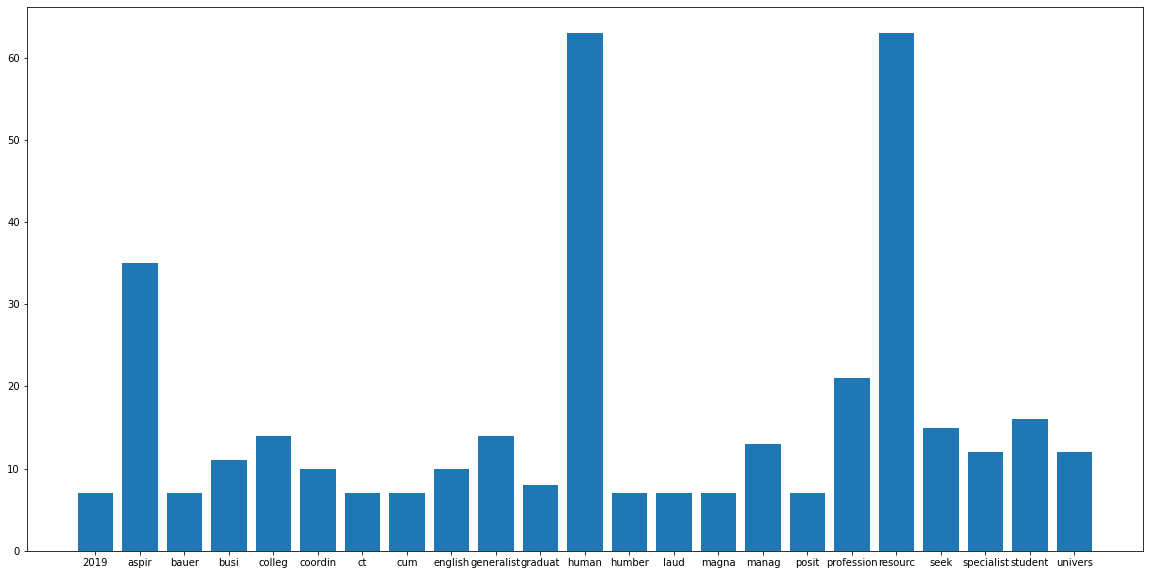

In [402]:
plt.figure(figsize=(20,10))
plt.bar(x=dict_display.keys(),height=dict_display.values())
plt.show()